## Cell Detachment with shear stress

A fração de ligações por área dado uma tensão de cisalhamento pode ser descrita como

$$
f(\tau_{\omega}, t) = 1 - \int_{0}^{\tau_{\omega}} p(\mu_{x}, \sigma_{x}, \tau) d\tau
$$
em que
$$
p(\mu_{x}, \sigma_{x}, \tau) = \frac{1}{\tau \sigma \sqrt{2 \pi}} \exp \left( - \frac{(\ln \tau - \mu)^{2}}{2 \sigma^{2}} \right)
$$

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def lognormal_pdf(x, mu, sigma):
    """
    Função de Densidade de Probabilidade (PDF) da distribuição log-normal.
    x: Variável (Shear Stress)
    mu: Média do logaritmo natural de x
    sigma: Desvio padrão do logaritmo natural de x
    """
    if x <= 0:  # PDF não definida para x <= 0
        return 0
    numerator = np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))
    denominator = x * sigma * np.sqrt(2 * np.pi)
    return numerator / denominator

In [15]:
def trapezoidal_integration(func, a, b, n_steps, mu, sigma):
    """
    Calcula a integral de uma função usando o método dos trapézios.
    func: A função a ser integrada (lognormal_pdf neste caso)
    a: Limite inferior de integração
    b: Limite superior de integração
    n_steps: Número de passos (subintervalos)
    mu, sigma: Parâmetros adicionais para a func (lognormal_pdf)
    """
    if n_steps <= 0:
        raise ValueError("Number of steps must be positive.")
    
    h = (b - a) / n_steps
    
    if a == 0:
        a = 1e-6 # Pequeno valor para evitar log(0)
    
    integral = 0.5 * (func(a, mu, sigma) + func(b, mu, sigma)) # Primeira e última parcela
    
    for i in range(1, n_steps):
        x_i = a + i * h
        integral += func(x_i, mu, sigma)
        
    return integral * h

In [16]:
# Definir a tensão de cisalhamento crítica (mediana)
tau_c = 48  # dyn cm^-2.

# Calcular mu com base em tau_c
mu_val = np.log(tau_c)

# Valores de sigma a serem plotados
sigmas = [0.1, 0.5, 1.0]

# Faixa de Shear Stress para o gráfico
shear_stress_range = np.linspace(0.1, 100, 200)

# Número de passos para a integração dos trapézios 
n_trap_steps = 1000 

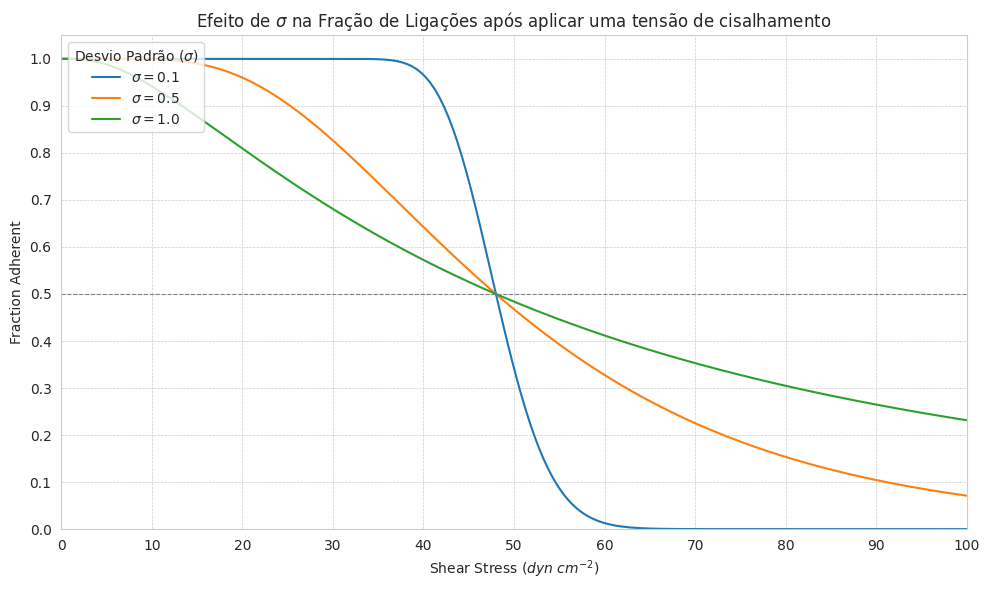

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Calcular e plotar a Fraction Adherent para cada sigma
for sigma_val in sigmas:
    fraction_adherent = []
    for tau_w in shear_stress_range:
        integral_start = max(1e-6, shear_stress_range[0]) # Começa em 1e-6 ou no primeiro ponto válido do range
        
        fraction_detached_at_tau_w = trapezoidal_integration(
            lognormal_pdf, integral_start, tau_w, n_trap_steps, mu_val, sigma_val
        )
        
        # A fração aderente é 1 menos a fração desprendida
        fraction_adherent.append(1 - fraction_detached_at_tau_w)
    
    plt.plot(shear_stress_range, fraction_adherent, label=f'$\sigma = {sigma_val}$')

# Adicionar a linha horizontal para 0.5 (mediana)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)

# Configurações do gráfico para corresponder à Figura 12.7
plt.xlabel('Shear Stress ($dyn~cm^{-2}$)')
plt.ylabel('Fraction Adherent')
plt.title('Efeito de $\sigma$ na Fração de Ligações após aplicar uma tensão de cisalhamento')
plt.xlim(0, 100)
plt.ylim(0, 1.05)
plt.legend(title='Desvio Padrão ($\sigma$)', loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

## Cálculo da Força e Torque variando parâmetros
Para células esféricas próximas à paredes, apenas tocando a superfície, temos
$$
F_{D} = 6 \pi \dot{\gamma} \mu a h F_{x} \left( \frac{a}{h} \right)
$$
$$
T = 4 \pi \dot{\gamma} \mu a^{3} M_{z} \left( \frac{a}{h} \right)
$$

com cálculos numéricos, aproximamos a
$$
F_{D} = 4.50 \dot{\gamma} \mu \pi a^{2}
$$
$$
T = 2.58 \dot{\gamma} \mu \pi a^{3}
$$

In [18]:
# Constantes da equação (para hemisfério)
C_FD = 4.50 * np.pi
C_T = 2.58 * np.pi

In [19]:
def calculate_forces_and_torques(gamma_dot, mu, a):
    """
    Calcula a Força de Arrasto (FD) e o Torque (T) para um hemisfério.
    gamma_dot: Taxa de cisalhamento (s^-1)
    mu: Viscosidade do fluido (Pa.s)
    a: Raio do hemisfério (m)
    """
    FD = C_FD * gamma_dot * mu * (a**2)
    T = C_T * gamma_dot * mu * (a**3)
    return FD, T

### Caso 1 - Variação da taxa de cisalhamento

In [20]:
mu_const = 1e-3  # Pa.s [cite: 308] (aproximado)
a_const_case1 = 5e-6 # m (5 micrometros) [cite: 303, 304] (raio típico da célula)

# Faixa de gamma_dot
gamma_dot_range = np.linspace(0, 200, 100) # s^-1

# Calcular FD e T
FD_case1, T_case1 = calculate_forces_and_torques(gamma_dot_range, mu_const, a_const_case1)

# Converter para unidades mais interpretáveis para plotagem
FD_case1_pN = FD_case1 * 1e12
T_case1_pN_um = T_case1 * 1e18


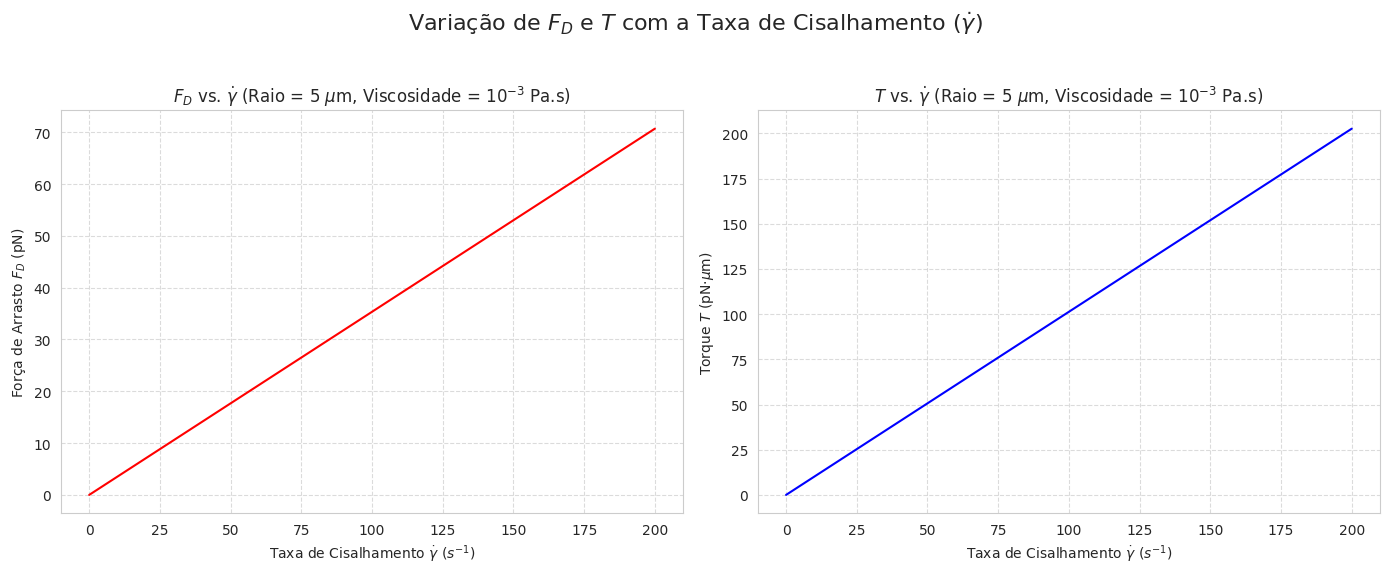

In [21]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 6))
fig1.suptitle(r'Variação de $F_D$ e $T$ com a Taxa de Cisalhamento ($\dot{\gamma}$)', fontsize=16)

# Plot FD vs gamma_dot
ax1[0].plot(gamma_dot_range, FD_case1_pN, color='red')
ax1[0].set_xlabel(r'Taxa de Cisalhamento $\dot{\gamma}$ ($s^{-1}$)')
ax1[0].set_ylabel(r'Força de Arrasto $F_D$ (pN)')
ax1[0].set_title(r'$F_D$ vs. $\dot{\gamma}$ (Raio = 5 $\mu$m, Viscosidade = $10^{-3}$ Pa.s)')
ax1[0].grid(True, linestyle='--', alpha=0.7)

# Plot T vs gamma_dot
ax1[1].plot(gamma_dot_range, T_case1_pN_um, color='blue')
ax1[1].set_xlabel(r'Taxa de Cisalhamento $\dot{\gamma}$ ($s^{-1}$)')
ax1[1].set_ylabel(r'Torque $T$ (pN$\cdot$$\mu$m)')
ax1[1].set_title(r'$T$ vs. $\dot{\gamma}$ (Raio = 5 $\mu$m, Viscosidade = $10^{-3}$ Pa.s)')
ax1[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição do título principal
plt.show()

### Caso 2: Variação com o Raio do Hemisfério (a)

In [22]:
# Parâmetros constantes para este caso
gamma_dot_const = 100  # s^-1
mu_const = 1e-3      # Pa.s

# Faixa de raio
a_range = np.linspace(1e-6, 15e-6, 100) # m (de 1 a 15 micrometros)

# Calcular FD e T
FD_case2, T_case2 = calculate_forces_and_torques(gamma_dot_const, mu_const, a_range)

# Converter para unidades mais interpretáveis para plotagem
FD_case2_pN = FD_case2 * 1e12
T_case2_pN_um = T_case2 * 1e18

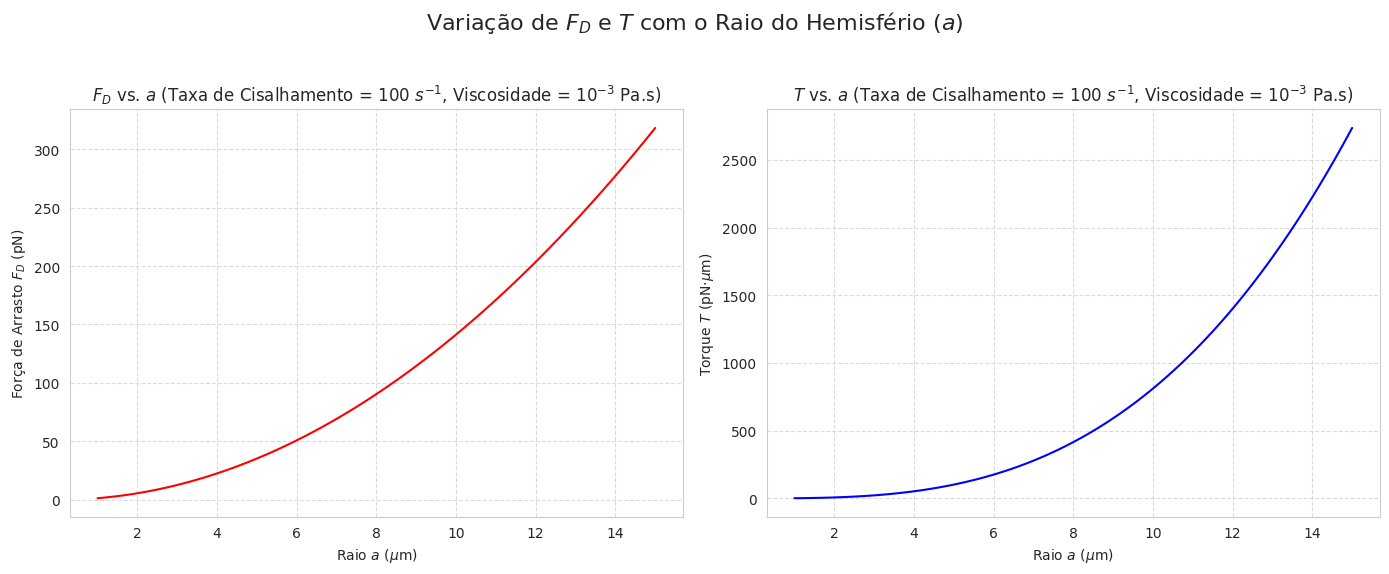

In [23]:
# Criar subplot para o Caso 2
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle(r'Variação de $F_D$ e $T$ com o Raio do Hemisfério ($a$)', fontsize=16)

# Plot FD vs a
ax2[0].plot(a_range * 1e6, FD_case2_pN, color='red') # Plotar raio em micrometros
ax2[0].set_xlabel(r'Raio $a$ ($\mu$m)')
ax2[0].set_ylabel(r'Força de Arrasto $F_D$ (pN)')
ax2[0].set_title(r'$F_D$ vs. $a$ (Taxa de Cisalhamento = $100$ $s^{-1}$, Viscosidade = $10^{-3}$ Pa.s)')
ax2[0].grid(True, linestyle='--', alpha=0.7)

# Plot T vs a
ax2[1].plot(a_range * 1e6, T_case2_pN_um, color='blue') # Plotar raio em micrometros
ax2[1].set_xlabel(r'Raio $a$ ($\mu$m)')
ax2[1].set_ylabel(r'Torque $T$ (pN$\cdot$$\mu$m)')
ax2[1].set_title(r'$T$ vs. $a$ (Taxa de Cisalhamento = $100$ $s^{-1}$, Viscosidade = $10^{-3}$ Pa.s)')
ax2[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Caso 3: Variação com a Viscosidade do Fluido (mu)

In [24]:
# Parâmetros constantes para este caso
gamma_dot_const = 100  # s^-1
a_const_case3 = 5e-6 # m

# Faixa de mu
mu_range = np.linspace(0.5e-3, 5e-3, 100) # Pa.s (de 0.5 a 5 mPa.s)

# Calcular FD e T
FD_case3, T_case3 = calculate_forces_and_torques(gamma_dot_const, mu_range, a_const_case3)

# Converter para unidades mais interpretáveis para plotagem
FD_case3_pN = FD_case3 * 1e12
T_case3_pN_um = T_case3 * 1e18

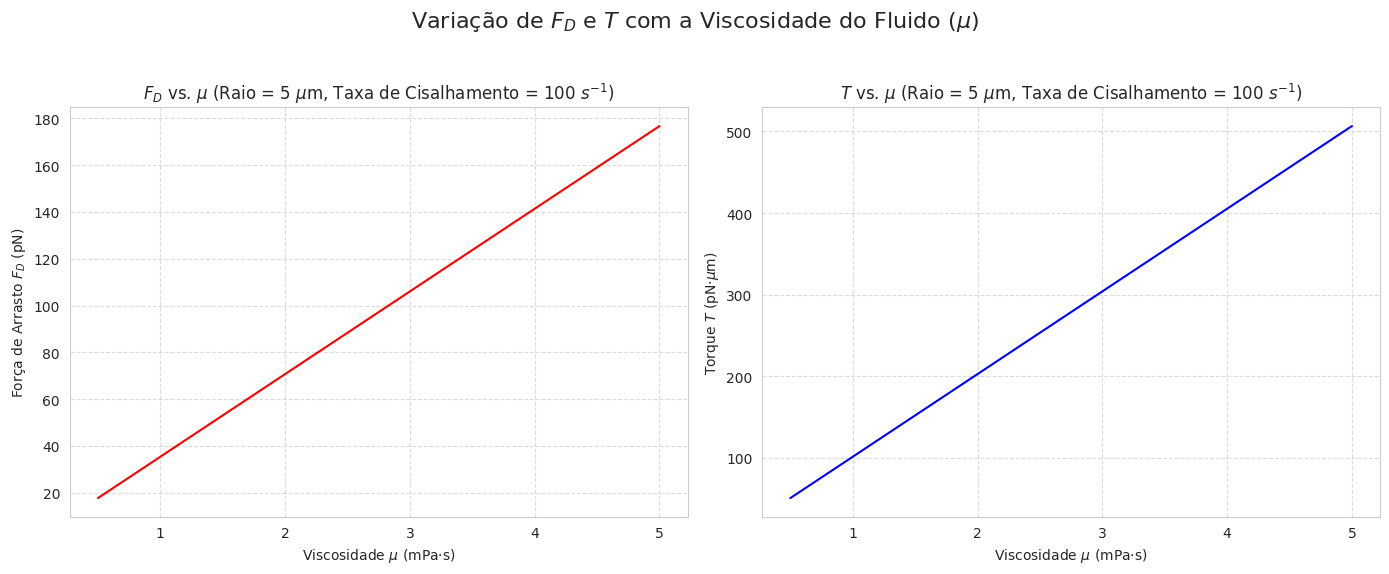

In [25]:
# Criar subplot para o Caso 3
fig3, ax3 = plt.subplots(1, 2, figsize=(14, 6))
fig3.suptitle(r'Variação de $F_D$ e $T$ com a Viscosidade do Fluido ($\mu$)', fontsize=16)

# Plot FD vs mu
ax3[0].plot(mu_range * 1e3, FD_case3_pN, color='red') # Plotar viscosidade em mPa.s
ax3[0].set_xlabel(r'Viscosidade $\mu$ (mPa$\cdot$s)')
ax3[0].set_ylabel(r'Força de Arrasto $F_D$ (pN)')
ax3[0].set_title(r'$F_D$ vs. $\mu$ (Raio = 5 $\mu$m, Taxa de Cisalhamento = $100$ $s^{-1}$)')
ax3[0].grid(True, linestyle='--', alpha=0.7)

# Plot T vs mu
ax3[1].plot(mu_range * 1e3, T_case3_pN_um, color='blue') # Plotar viscosidade em mPa.s
ax3[1].set_xlabel(r'Viscosidade $\mu$ (mPa$\cdot$s)')
ax3[1].set_ylabel(r'Torque $T$ (pN$\cdot$$\mu$m)')
ax3[1].set_title(r'$T$ vs. $\mu$ (Raio = 5 $\mu$m, Taxa de Cisalhamento = $100$ $s^{-1}$)')
ax3[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()